In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers datasets huggingface_hub tensorboard==2.11
!sudo apt-get install git-lfs --yes


import json
import torch
from datasets import load_dataset
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, TrainingArguments, Trainer
from huggingface_hub import HfFolder, notebook_login
! pip install transformers[torch] -U
! pip install accelerate -U


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [3]:
import  argparse
import pandas as pd
import json
import numpy as np


In [4]:
with open("/content/drive/MyDrive/Marcus_Project/removed_n/arxiv_chatGPT_train.jsonl", "r") as file:
    train_data = [json.loads(line) for line in file]

with open("/content/drive/MyDrive/Marcus_Project/removed_n/arxiv_chatGPT_val.jsonl", "r") as file:
    val_data = [json.loads(line) for line in file]



In [5]:
train_data[0]

{'prompt': 'Generate a 150-220-word abstract for work with title: Supersymmetric Q Solitons of Arbitrary Genus. Describe the key ideas and methodology, the motivation for the research, and the results obtained in a formal academic and scientific writing voice. Use the first plural person form. Use active voice.',
 'human_text': '  We construct "Flying Saucer" solitons in supersymmetric N=2 gauge theory which is known to support BPS domain walls with a U(1) gauge field localized on its worldvolume. We demonstrate that this model supports exotic particle-like solitons whose topology is largely arbitrary: closed orientable surfaces in three-dimensional space which can have arbitrary genus. In particular, we focus on Q tori. Q tori and similar solitons of higher genera are obtained by folding the domain wall into an appropriate surface. Nontrivial cycles on the domain wall worldvolume (handles) are stabilized by crossed electric and magnetic fields inside the folded domain wall. Three dist

In [6]:
val_data[0]

{'prompt': 'Generate a 150-220-word abstract for work with title: Ultimate Fate of our Universe from Quantum Mechanics. Describe  problem work attempts to solve, the results obtained, and the key ideas and methodology in a formal academic and scientific writing voice. Use the first plural person form. Use active voice.',
 'human_text': '  It is conjectured that time intervals of any kind are proportional to the age of the Universe taken at the time we are considering the interval. If this is the case then the speed of light, in fact any speed, must decrease inversely proportional to this age. The immediate consequence is that energy is not conserved: the hypothesis that time is a homogeneous property implies conservation of energy (the theorem of Noether). Nonconservation of energy follows from the condition that any time interval is proportional to the cosmological time, and therefore time can not be homogeneous. From the uncertainty principle, taking the constant of Planck as a real 

In [8]:
from datasets import Dataset

def prepare_dataset(data, abstract = "human_text", machine_abstract = "machine_text"):
    examples = []
    labels = []

    # Append text and labels for human and machine texts
    for example in data:
        examples.append(example[abstract])
        labels.append(0)  # Human text label
        examples.append(example[machine_abstract])
        labels.append(1)  # Machine text label

    # Creating a dataset
    dataset = Dataset.from_dict({"text": examples, "labels": labels})
    return dataset


In [8]:
from datasets import Dataset
# Prepare datasets
train_dataset = prepare_dataset(train_data)
validation_dataset = prepare_dataset(val_data)


In [9]:
print("Size of the train dataset:", len(train_dataset))
print("Size of the validation dataset:", len(validation_dataset))


Size of the train dataset: 3840
Size of the validation dataset: 960


In [4]:
import torch
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    AutoConfig
)
from sklearn.metrics import accuracy_score


In [11]:
#Logging in into Hugging Face
notebook_login()


In [12]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer and model
model_name = "andreas122001/roberta-academic-detector"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [13]:
# Tokenize the text data
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length = 512)



In [14]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
validation_dataset = validation_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/3840 [00:00<?, ? examples/s]

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

In [15]:
print(train_dataset)

Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 3840
})


In [16]:
# TrainingArguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Marcus_Project/removed_n",
    num_train_epochs=3,
    per_device_train_batch_size=4,  # Adjusted for potential GPU memory constraints
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    logging_dir="/content/drive/MyDrive/Marcus_Project/removed_n",
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=2,
    report_to="tensorboard",
    push_to_hub=False,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [18]:
# Fine-tune the model
trainer.train()

evaluation_results = trainer.evaluate()
print(evaluation_results)



Epoch,Training Loss,Validation Loss
1,0.000000,0.011882
2,0.000000,0.000014


Epoch,Training Loss,Validation Loss
1,0.000000,0.011882
2,0.000000,0.000014
3,0.000000,0.000021


{'eval_loss': 1.376136606268119e-05, 'eval_runtime': 34.3344, 'eval_samples_per_second': 27.96, 'eval_steps_per_second': 6.99, 'epoch': 3.0}


##Saving the model


In [19]:
import os

# Define the directory in Google Drive where you want to save the model
output_dir = "/content/drive/MyDrive/Marcus_Project/removed_n"

# Make sure the directory exists, if not create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the trained model and tokenizer
model_path = os.path.join(output_dir, "model")
trainer.model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)


trainer.model.config.save_pretrained(model_path)



In [5]:
from transformers import pipeline
from transformers import TextClassificationPipeline
# Load the tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained("/content/drive/MyDrive/Marcus_Project/removed_n/model",  model_max_length = 512)
model = RobertaForSequenceClassification.from_pretrained("/content/drive/MyDrive/Marcus_Project/removed_n/model")
#classifier = pipeline('text-classification',"/content/drive/MyDrive/Marcus_Project/removed_n/model")
# Initialize the TextClassificationPipeline
classifier = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    top_k=1,
    truncation=True,  # Ensures that input sequences are truncated
    padding=True      # Pads sequences to the maximum length
)


##Testing chatgpt dataset

In [33]:
test_data_path = "/content/drive/MyDrive/Marcus_Project/removed_n/arxiv_chatGPT_test.jsonl"
# Load datasets
with open(test_data_path, "r") as file:
    test_data = [json.loads(line) for line in file]


In [34]:
# Prepare datasets
gpt_test_data = prepare_dataset(test_data)
print("Size of the dataset:", len(gpt_test_data))


Size of the dataset: 1200


In [15]:
# Make predictions
# predictions = pipeline(test_dataset["text"])

# Define classification function
def classify_text(example):
    try:
        predictions = classifier(example['text'])
        return {'predicted_labels': predictions[0][0]['label']}
    except Exception as e:
        #print(f"Error processing example: {example['text']}")
        print(e)
        return {'predicted_labels': None}



In [36]:
# Apply the classification to all texts in the dataset and add the predicted_labels column
gpt_test_data = gpt_test_data.map(classify_text, batched=False)
# Check the first few entries to verify
print(gpt_test_data[0])

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


Error processing example:   The 105-ms X-ray pulsar J1852+0040 is the central compact object (CCO) in SNR Kes 79. We report a sensitive upper limit on its radio flux density of 12 uJy at 2 GHz using the NRAO GBT. Timing using XMM and Chandra over a 2.4 yr span reveals no significant change in its spin period. The 2 sigma upper limit on the period derivative leads, in the dipole spin-down formalism, to an energy loss rate E-dot < 7e33 ergs/s, surface magnetic field strength B_p < 1.5e11 G, and characteristic age tau_c = P/2P-dot > 8 Myr. This tau_c exceeds the age of the SNR by 3 orders of magnitude, implying that the pulsar was born spinning at its current period. However, the X-ray luminosity of PSR J1852+0040, L(bol) ~ 3e33(d/7.1 kpc)^2 ergs/s is a large fraction of E-dot, which challenges the rotation-powered assumption. Instead, its high blackbody temperature, 0.46+/-0.04 keV, small blackbody radius ~ 0.8 km, and large pulsed fraction, ~ 80%, may be evidence of accretion onto a pol

In [39]:
print(gpt_test_data)


Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1200
})


In [41]:
df_test_dataset_gpt = gpt_test_data.to_pandas()
df_test_dataset_gpt['target_labels'] = df_test_dataset_gpt['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')


In [51]:
# Replace None with NaN for proper handling by dropna
df_test_dataset_gpt['predicted_labels'].replace({None: pd.NA}, inplace=True)

# Drop rows where 'predicted_labels' is None (NaN)
df_test_dataset_gpt = df_test_dataset_gpt.dropna(subset=['predicted_labels'])


In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


Unique values in predicted_labels: {'machine-generated', 'human-produced'}
Unique values in true_labels: {'machine-generated', 'human-produced'}
Confusion Matrix in Percentage:
[[100.   0.]
 [  0. 100.]]


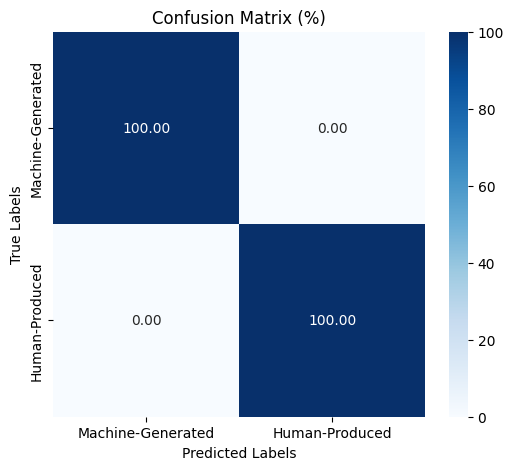

In [53]:
predicted_labels = df_test_dataset_gpt.predicted_labels.to_list()
true_labels = df_test_dataset_gpt.target_labels.to_list()
# Print unique values
print("Unique values in predicted_labels:", set(predicted_labels))
print("Unique values in true_labels:", set(true_labels))

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


In [54]:
import numpy as np
# Extracting TP, TN, FP, FN
TP = cm[0, 0]  # True Positive: correct machine-generated predictions
FN = cm[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")



Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


###try to batch the next testing and cehck truncation

##Testing Coher Data

In [6]:
import json
test_data_path = "/content/drive/MyDrive/Marcus_Project/removed_n/arxiv_cohere_test.jsonl"
# Load datasets
with open(test_data_path, "r") as file:
    test_data = [json.loads(line) for line in file]

In [10]:
# Prepare datasets
coher_test_data = prepare_dataset(test_data)
print("Size of the dataset:", len(coher_test_data))

Size of the dataset: 1200


In [16]:
# Apply the classification to all texts in the dataset and add the predicted_labels column
coher_test_data = coher_test_data.map(classify_text, batched=False)
# Check the first few entries to verify
print(coher_test_data[0])

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': "  We address the problem of constructing high-accuracy, faithful analytic waveforms describing the gravitational wave signal emitted by inspiralling and coalescing binary black holes. We work within the Effective-One-Body (EOB) framework and propose a methodology for improving the current (waveform)implementations of this framework based on understanding, element by element, the physics behind each feature of the waveform, and on systematically comparing various EOB-based waveforms with ``exact'' waveforms obtained by numerical relativity approaches. The present paper focuses on small-mass-ratio non-spinning binary systems, which can be conveniently studied by Regge-Wheeler-Zerilli-type methods. Our results include: (i) a resummed, 3PN-accurate description of the inspiral waveform, (ii) a better description of radiation reaction during the plunge, (iii) a refined analytic expression for the plunge waveform, (iv) an improved treatment of the matching between the plunge and rin

In [19]:
df_test_dataset_coher = coher_test_data.to_pandas()
df_test_dataset_coher['target_labels'] = df_test_dataset_coher['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')


Unique values in predicted_labels: {'human-produced', 'machine-generated'}
Unique values in true_labels: {'human-produced', 'machine-generated'}
Confusion Matrix in Percentage:
[[ 91.33333333   8.66666667]
 [  0.         100.        ]]


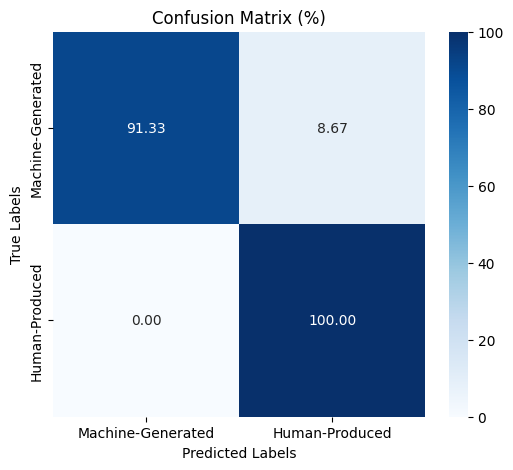

In [20]:
predicted_labels = df_test_dataset_coher.predicted_labels.to_list()
true_labels = df_test_dataset_coher.target_labels.to_list()
# Print unique values
print("Unique values in predicted_labels:", set(predicted_labels))
print("Unique values in true_labels:", set(true_labels))

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


In [21]:
import numpy as np
# Extracting TP, TN, FP, FN
TP = cm[0, 0]  # True Positive: correct machine-generated predictions
FN = cm[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")



Accuracy: 0.9567
Precision: 1.0000
Recall: 0.9133


##Testing Flant Data


In [22]:
import json
test_data_path = "/content/drive/MyDrive/Marcus_Project/removed_n/arxiv_flant5_test.jsonl"
# Load datasets
with open(test_data_path, "r") as file:
    test_data = [json.loads(line) for line in file]

In [23]:
# Prepare datasets
flant_test_data = prepare_dataset(test_data)
print("Size of the dataset:", len(flant_test_data))

Size of the dataset: 1200


In [25]:
# Apply the classification to all texts in the dataset and add the predicted_labels column
flant_test_data = flant_test_data.map(classify_text, batched=False)
# Check the first few entries to verify


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [26]:
df_test_dataset_flant = flant_test_data.to_pandas()
df_test_dataset_flant['target_labels'] = df_test_dataset_flant['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')


Unique values in predicted_labels: {'human-produced', 'machine-generated'}
Unique values in true_labels: {'human-produced', 'machine-generated'}
Confusion Matrix in Percentage:
[[ 44.5  55.5]
 [  0.  100. ]]


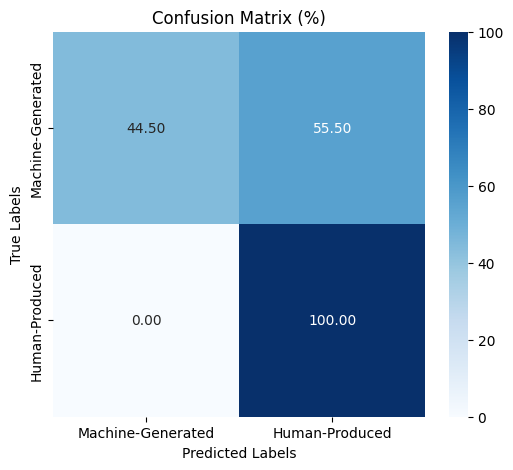

In [27]:
predicted_labels = df_test_dataset_flant.predicted_labels.to_list()
true_labels = df_test_dataset_flant.target_labels.to_list()
# Print unique values
print("Unique values in predicted_labels:", set(predicted_labels))
print("Unique values in true_labels:", set(true_labels))

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


In [28]:
import numpy as np
# Extracting TP, TN, FP, FN
TP = cm[0, 0]  # True Positive: correct machine-generated predictions
FN = cm[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")



Accuracy: 0.7225
Precision: 1.0000
Recall: 0.4450


##Testing Davinci Data

In [29]:
import json
test_data_path = "/content/drive/MyDrive/Marcus_Project/removed_n/arxiv_davinci_test.jsonl"
# Load datasets
with open(test_data_path, "r") as file:
    test_data = [json.loads(line) for line in file]

In [30]:
# Prepare datasets
davinci_test_data = prepare_dataset(test_data)
print("Size of the dataset:", len(davinci_test_data))

Size of the dataset: 1200


In [32]:
# Apply the classification to all texts in the dataset and add the predicted_labels column
davinci_test_data = davinci_test_data.map(classify_text, batched=False)
# Check the first few entries to verify

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [33]:
df_test_dataset_davinci = davinci_test_data.to_pandas()
df_test_dataset_davinci['target_labels'] = df_test_dataset_davinci['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')


Unique values in predicted_labels: {'human-produced', 'machine-generated'}
Unique values in true_labels: {'human-produced', 'machine-generated'}
Confusion Matrix in Percentage:
[[ 82.83333333  17.16666667]
 [  0.         100.        ]]


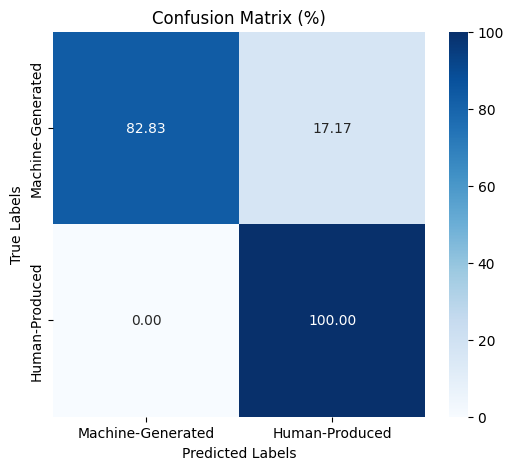

In [34]:
predicted_labels = df_test_dataset_davinci.predicted_labels.to_list()
true_labels = df_test_dataset_davinci.target_labels.to_list()
# Print unique values
print("Unique values in predicted_labels:", set(predicted_labels))
print("Unique values in true_labels:", set(true_labels))

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


In [35]:
import numpy as np
# Extracting TP, TN, FP, FN
TP = cm[0, 0]  # True Positive: correct machine-generated predictions
FN = cm[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")



Accuracy: 0.9142
Precision: 1.0000
Recall: 0.8283
